## Setup & Import
- import torch + numpy + other libs needed
- get current device

In [ ]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Data (MNIST, handwritten digits 0–9)

Load MNIST dataset and create a dataloader. The dataloader should include a **preprocessing pipeline** for the images in the dataset that:

- convert each MNIST image (which comes as a PIL image) into a PyTorch tensor, with pixel values scaled from [0, 255] to [0, 1] --> use toTensor()
- rescale those values from [0, 1] to [-1, 1] (which is the range expected by the neural network) --> use Normalize((0.5,), (0.5,)). Formula: (x - mean) / std -> (x - 0.5) / 0.5.

Data loader requires as well the **MNIST dataset** (dataset.MNIST). Parameters:
- root="./data" -> where to store the dataset locally.
- train=True -> load the training split (60,000 images).
- download=True -> automatically download the dataset if it’s not already in ./data.
- transform=transform -> apply the preprocessing pipeline defined (tensor conversion + normalization).

Now you can **wrap the dataset in a DataLoader**, which handles batching, shuffling, and loading data efficiently. Parameters:
- trainset
- batch_size
- shuffle=True -> randomly shuffles the dataset each epoch (important so the model doesn’t see the data in the same order every time).
- num_workers=2 -> uses 2 subprocesses to load data in parallel, speeding up data loading.
- pin_memory=True -> allows faster data transfer to GPU if available.



In [ ]:
batch_size = 32

# create data processing pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # -> [-1, 1]
])

# load and store locally the dataset
trainset = datasets.MNIST(root="../data/MNIST", train=True, download=True, transform=transform)
print('Total images', len(trainset))

# create the dataloader
loader   = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
print('number of batches per epoch (total images ÷ batch size)', len(loader))

Total images 60000
number of batches per epoch (total images ÷ batch size) 1875


## Models (Generator e Discriminator with simple MLPs)

Let's start with the simplest option (using MLPs for both generator and discriminator).

### GENERATOR
The Generator takes a random noise vector (latent code, size = 100) as input and transforms it into an image shaped like MNIST digits (28×28 pixels, grayscale).

The philosophy is to start expanding the latent vector to something larger through several layers (e.g., 100 --> 512 --> 1024) and then match the image size (1024 --> 784) in the output layer. This gradual increase is necessary, since if you try to jump directly from 100 --> 784, the Generator may not have enough parameters to learn the complex patterns of digits. Adding intermediate hidden layers allows it to build richer internal representations step by step.

In DCGAN (for larger images), instead of fully connected layers, use deconvolutions with progressively increasing resolution, with the same philosophy: expand from a compact latent code into a structured, high-dimensional image.

Then, there are some "recipe tricks" to consider. First, GAN training is unstable by nature since the Generator and Discriminator are in constant competition. One trick to stabilize the generator is using BatchNorm since:
- keeps activations in a consistent scale and distribution.
- prevents exploding/vanishing gradients
- makes training less sensitive to initialization.

As activation, use ReLU or LeakyReLU.

Important note: BatchNorm is not used in the final layer which uses as activation Tanh. This is crucial. The training images (MNIST) were normalized to the range [-1, 1]. If the Generator’s output isn’t in the same range, the Discriminator would immediately know the samples are “fake” just from scale differences.

Tanh naturally outputs values in [-1, 1], making the Generator’s output directly comparable to real MNIST data.

In [ ]:
# dimension of the latent space
z_dim    = 100

class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(

            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.net(z)  # (B, 784)
        return x.view(-1, 1, 28, 28)

### DISCRIMINATOR
The discriminator is  a binary classifier: given an image, it predicts how likely it is to be real (from MNIST) vs fake (from the Generator).

Since we use an MLP as discriminator, the image must first be flattened. Then we increase the size of the hidden layers and then decrease until outputting a single logit (e.g., 784 -> 1024 -> 512 -> 1). The discriminator should be right-sized capacity: big enough to challenge G, small enough not to instantly overpower it (which could stop G from learning).

LeakyReLU are usually used as activations, and no BatchNorm is used (which would facilitate the discriminator work).
Trick: optionally, use Dropout in D to reduce overfitting to artifacts and mitigate mode collapse.

NOTE: BCELoss is commonly used fro the discriminator. So there are two choices:
- BCELoss, which requires that the model outputs a probability (with a Sigmoid)
- BCEWithLogitsLoss, which takes as input not the probability but directly the logits

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),

            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1)
        )
    def forward(self, x):
        return self.net(x).view(-1)

# create generator, discrimintaor and count their parameters
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
print('Generator parameters =', sum(p.numel() for p in G.parameters()),
       '\nDiscriminator parameters =', sum(p.numel() for p in D.parameters()))

Generator parameters = 1383696 
Discriminator parameters = 1329153


## Loss, and optimizers (and utilities...)

As loss, we can pick any of the two options explained before. BCEWithLogitsLoss() combines Sigmoid + BCE in a numerically stable way (better gradients, fewer overflow/underflow issues than manual sigmoid + BCELoss).

Then the two optimizers (use Adam) for G and D should be defined using suitable parameters (e.g., learning rate = 2e-4, betas = (0.5, 0.999)).

Trick: using label smoothing for real examples (e.g. 0.9 instead of 1.0)  discourages the discriminator from becoming overconfident (i.e., the discriminator quickly assigns high scores to real and very low scores to fakes; if this happens the gradint of the generator vanishes). This trick often improves training dynamics and helps the generator learn better. Fake remains 0.0 (hard negative). These values can be fed as targets to the BCE loss.

Finally, create a set of fixed latent codes to visualize generation progresses.


In [ ]:
# we take the option of using BCEWithLogits as loss...
criterion = nn.BCEWithLogitsLoss()

# creating the optimizers
optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

real_label = 0.9   # label smoothing
fake_label = 0.0

# fixed z (64 images) to show progresses
torch.manual_seed(0)
fixed_z = torch.randn(64, z_dim, device=device)

# create an output directory to save generated images for later use...
os.makedirs("samples", exist_ok=True)

def show_grid(tensor, title=None, nrow=8):
    """ shows an image grid (tensor in [-1,1]) in Colab."""
    imgs = (tensor.clamp(-1,1) + 1)/2  # -> [0,1]
    grid = utils.make_grid(imgs, nrow=nrow, padding=2, normalize=False)
    npimg = grid.detach().cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.axis("off")
    if title: plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap="gray")
    plt.show()

## Training loop

Training is a two-player game:
- the Generator maps random noise to fake MNIST images
- the Discriminator receives an image and outputs a score (logit) for real vs fake.

At each iteration:
- Update D, by using real images from dataloader + fake images from the generator (G is not updated in this step)
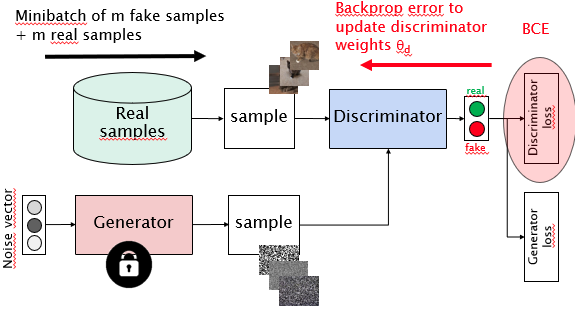
- Update G, by using fake images only (D is not updated in this step)
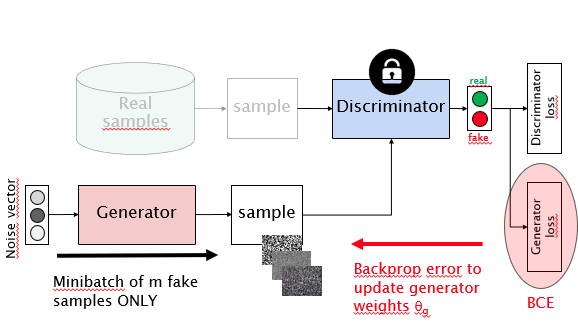

Losses:
- Discriminator loss: D sees ywo kind of inputs, real and fake, so the total D loss is the sum of the loss on real (y_real = 1/0.9) and the loss on fake (y_fake = 0)
- Generator loss: G wants to fool D, but remember the probelm of vanishing gradient -> one possible solution is to maximize the probability that D makes mistakes -> so fakes are assignd as label y_real, and then we compute the loss on that

You repeat this over multiple epochs. As D improves at spotting fakes, G is pushed to produce more realistic digits; as G improves, D must refine its decision boundary.

NOTE: take care that the number of batch images may be smaller than the batch size for the last batch... compute the real batch size at each iteration



Salvato: samples/epoch_10.png


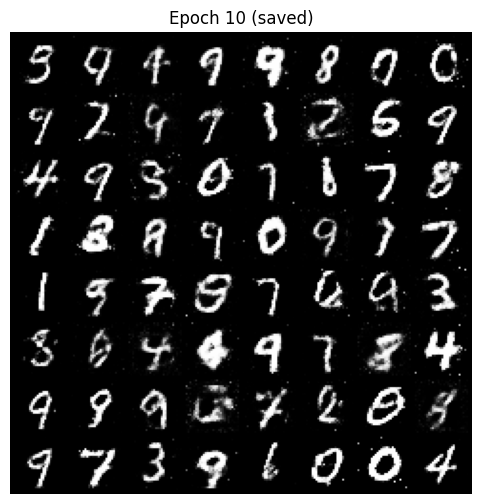

In [ ]:
epochs = 10

for epoch in range(1, epochs+1):
    # we don't need GT labels here
    for i, (real, _) in enumerate(loader):
        real = real.to(device)
        b = real.size(0)

        # Crear el ruido
        noise = torch.randn(b, z_dim, device=device)

        # ======== Update D ========
        # D in train mode and clean grads.
        D.train() # Train mode
        optD.zero_grad() # Clear grads

        # 1. feed real images into D
        real_output = D(real) # Pasamos la imagen
        real_labels = torch.full((b,), real_label, dtype=torch.float, device=device)
        loss_real = criterion(real_output, real_labels) # Usamos el criterio
        loss_real.backward() # Backpropagation

        # 2. feed fake images into D (stop gradient through G) - note: use torch.no_grad() or G.detach()
        with torch.no_grad():
            fake = G(noise).detach()

        fake_output = D(fake) # Pasamos la imagen
        fake_labels = torch.full((b,), fake_label, dtype=torch.float, device=device)
        loss_fake = criterion(fake_output, fake_labels) # Usamos el criterio
        loss_fake.backward() # Backpropagation

        # 3. compute loss and backprop for D
        loss_D = loss_real + loss_fake
        optD.step()

        # ======== Update G ========
        # put G intraining mode and zero its gradient
        G.train() # Train mode
        optG.zero_grad() # Clear grads

        # 1. feed fake images into D
        fake = G(noise)
        fake_output_G = D(fake)

        # 2. compute loss and backprop for G
        labels_G = torch.full((b,), real_label, dtype=torch.float, device=device)
        loss_G = criterion(fake_output_G, labels_G)
        loss_G.backward()
        optG.step()

        # ======== logging ========
        # log each 200 steps and show progress
        if (i % 200 == 0):
            clear_output(wait=True)
            print(f"[{epoch:02d}/{epochs:02d}] step {i:04d} | loss_D={loss_D.item():.3f}  loss_G={loss_G.item():.3f}")
            with torch.no_grad():
                G.eval()
                samples = G(fixed_z)
            show_grid(samples, title=f"Epoch {epoch}  |  Step {i}")

    # epoch end: save a grid on disk and show progress
    with torch.no_grad():
        G.eval()
        samples = G(fixed_z)

    # before saving images, denormalizes them in [0,1]
    utils.save_image((samples+1)/2, f"samples/epoch_{epoch:02d}.png", nrow=8)
    clear_output(wait=True)
    print(f"Salvato: samples/epoch_{epoch:02d}.png")
    show_grid(samples, title=f"Epoch {epoch} (saved)")